# The Mathematical Engineering of Deep Learning

## Practical 4 (Julia version)
**For an R or Python version see the [course website](https://deeplearningmath.org/)**.

---

In this practical we will carry out some basic EDA and analysis of some popular ML Datasets that will be used in the course.

---

# Goals

In this tutorial, we mainly use the MNIST dataset to explore classification using deep neural networks (DNN) models.
At the end of this tutorial, you should be comfortable to use a software package (here `Flux.jl`) to run different models for a classification task.  You will explore different models by exploring/tuning different hyperparamaters of the DNN: 

- number of layers and nodes
- batch normalization
- regularization technique
- dropout 
- weight initialization


# MNIST

**Reminder**: Keep in mind that all features need to be numeric for running a feedforward DNN. When you have some categorical features you have to transform into numerical values such as one-hot encoded. 

In [4]:
using Flux.Data.MNIST

trainLabels = MNIST.labels()
trainImgs = MNIST.images()

testLabels = MNIST.labels(:test)
testImgs = MNIST.images(:test);

In [5]:
@show trainLabels[1]
trainImgs[1]

trainLabels[1] = 5


# Scale the data set

The data is in gray scale with each image having 0 to 255 values. In general we would need to scale it, but Julia does this for us...

In [6]:
typeof(trainImgs[1])

Array{ColorTypes.Gray{FixedPointNumbers.Normed{UInt8,8}},2}

In [7]:
extrema(Float32.(trainImgs[1]))

(0.0f0, 1.0f0)

# Transform the outcome 

For multi-classification model (multinomial response 0 to 9), `Flux.jl` uses one-hot encoded for the outcome


In [8]:
using Flux: onehotbatch

In [9]:
? onehotbatch

search:



```
onehotbatch(ls, labels[, unk...])
```

Return a `OneHotMatrix` where `k`th column of the matrix is `onehot(ls[k], labels)`.

If one of the input labels `ls` is not found in `labels` and `unk` is given, return [`onehot(unk, labels)`](@ref) ; otherwise the function will raise an error.

# Examples

```jldoctest
julia> Flux.onehotbatch([:b, :a, :b], [:a, :b, :c])
3×3 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  1  0
 1  0  1
 0  0  0
```


In [11]:
onehotbatch(trainLabels,0:9)

10×60000 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  1  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  1  0  1  0  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  1  0  0  1  0  1     0  0  0  0  0  0  0  0  1  0  0  0
 0  0  1  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  1  0  …  0  0  0  0  0  1  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  1  0  0  0  0  0  1  0  0  0  1
 0  0  0  0  1  0  0  0  0  0  0  0  0     0  0  1  0  1  0  0  0  0  0  0  0

# Organize the data

In [18]:
batchSize = 128
validateFraction = 0.2
numTrain = length(trainImgs)
trainRange, validateRange = 1:Int(numTrain*(1-validateFraction)), (Int(numTrain*(1-validateFraction))+1):60000

function minibatch(x, y, indexRange)
    xBatch = Array{Float32}(undef, size(x[1])..., 1, length(indexRange))
    for i in 1:length(indexRange)
        xBatch[:, :, :, i] = Float32.(x[indexRange[i]])
    end
    return (xBatch, onehotbatch(y[indexRange], 0:9))#A tuple of 
end

mbIdxs = Iterators.partition(1:length(trainImgs), batchSize)
trainSet = [minibatch(trainImgs, trainLabels, bi) for bi in mbIdxs]
oneBatchTrainSet =  minibatch(trainImgs, trainLabels, 1:length(trainImgs))

validateLabels = MNIST.labels()[validateRange]
validateImgs = MNIST.images()[validateRange]
validateSet = minibatch(validateImgs, validateLabels, 1:length(validateImgs))

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

...

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 1; 0 0 … 0 0])

# Implementation a DNN using `Flux.jl`


In [28]:
using Flux, Flux.Data.MNIST, Statistics, Random, Plots; pyplot()
using Flux: onehotbatch, onecold, crossentropy
Random.seed!(0)

epochs = 25
η = 0.01
model= Chain(flatten, 
             Dense(784, 128,relu),
             Dense(128,64,relu),
             Dense(64, 10), softmax)

accuracy(x, y, model) = mean(onecold(model(x)) .== onecold(y))
loss(x, y, model) = crossentropy(model(x), y)

function trainModel(model;epochs = 25,opt = ADAM(η),verbose = true)
    trainingLosses, validationLosses = [], []
    trainingAccuracy, validationAccuracy = [], []
    function updateAfterEpcoh()
        push!(trainingLosses, loss(oneBatchTrainSet..., model))
        push!(validationLosses, loss(validateSet..., model))
        push!(trainingAccuracy,accuracy(oneBatchTrainSet..., model))
        push!(validationAccuracy,accuracy(validateSet..., model))
    end

    model(trainSet[1][1]) #speedup by running once
    for ep in 1:epochs
        Flux.train!((x,y)->loss(x,y,model), params(model), trainSet, opt)
        updateAfterEpcoh()
        verbose && println("$(ep): Validation Accuracy: $(round(last(validationAccuracy),digits=3))")
    end
    return (trainingLosses, validationLosses, trainingAccuracy, validationAccuracy)
end

traces = trainModel(model)
println("\nFinal validation accuracy = ", accuracy(validateSet..., model))

1: Validation Accuracy: 0.954
2: Validation Accuracy: 0.976
3: Validation Accuracy: 0.978
4: Validation Accuracy: 0.984
5: Validation Accuracy: 0.983
6: Validation Accuracy: 0.979
7: Validation Accuracy: 0.989
8: Validation Accuracy: 0.986
9: Validation Accuracy: 0.981
10: Validation Accuracy: 0.984
11: Validation Accuracy: 0.992
12: Validation Accuracy: 0.988
13: Validation Accuracy: 0.978
14: Validation Accuracy: 0.994
15: Validation Accuracy: 0.986
16: Validation Accuracy: 0.992
17: Validation Accuracy: 0.99
18: Validation Accuracy: 0.994
19: Validation Accuracy: 0.991
20: Validation Accuracy: 0.991
21: Validation Accuracy: 0.989
22: Validation Accuracy: 0.993
23: Validation Accuracy: 0.992
24: Validation Accuracy: 0.991
25: Validation Accuracy: 0.99

Final validation accuracy = 0.9899166666666667


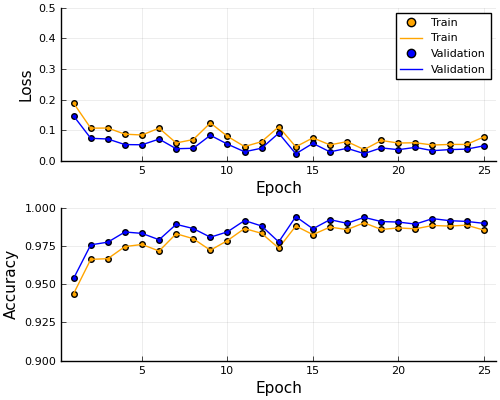

In [29]:
function plotModel(traces)
    trainingLosses, validationLosses = traces[1], traces[2]
    trainingAccuracy, validationAccuracy = traces[3], traces[4]

    p1 = plot(trainingLosses,label="Train", ylim=(0.0,0.5), xlabel="Epoch", 
            ylabel = "Loss",c=:orange,seriestype = [:scatter,:line])
         plot!(validationLosses,label="Validation",c=:blue,seriestype = [:scatter,:line])

    p2 = plot(trainingAccuracy,label="Train", ylim=(0.9,1.0), xlabel="Epoch", 
            ylabel = "Accuracy",legend=false,c=:orange,seriestype = [:scatter,:line])
         plot!(validationAccuracy,label="Validation",c=:blue,seriestype = [:scatter,:line])

    plot(p1,p2,layout=(2,1),size=(500,400))
end

plotModel(traces)

We can see that the loss function improves rapidly. However, we can see a potential overfit after 10 epochs. Indeed, the accurary rate of the validation set presents a flat shape after 10 epochs.

# Considering the test set

In [36]:
#creating a predictor function (packaging the neural network)
exampleImage = testImgs[1]

In [38]:
reshapedExampleImage = reshape(Float32.(exampleImage),784,1)

784×1 Array{Float32,2}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [40]:
exampleModelOutput = model(reshapedExampleImage)

10×1 Array{Float32,2}:
 0.0
 3.361f-40
 4.5305f-41
 0.0
 0.0
 0.0
 0.0
 1.0
 0.0
 1.0840842f-35

In [41]:
onecold(exampleModelOutput)

1-element Array{Int64,1}:
 8

In [45]:
first(onecold(exampleModelOutput)) - 1

7

In [46]:
predictor(img,model) = first(onecold(model(reshape(Float32.(img),784,1))))-1

predictor (generic function with 1 method)

In [47]:
predictor(exampleImage,model)

7

In [52]:
preds = [predictor(img,model) for img in testImgs]

10000-element Array{Int64,1}:
 7
 2
 1
 0
 4
 1
 4
 9
 5
 9
 0
 6
 9
 ⋮
 5
 6
 7
 8
 9
 0
 1
 2
 3
 4
 5
 6

In [53]:
testAccuracy = sum(preds .== testLabels)/length(preds)

0.9683

In [61]:
confusionMatrix = 
    [sum([predictor(img,model) .== i for img in testImgs[testLabels .== j]]) 
        for i in 0:9, j in 0:9]

10×10 Array{Int64,2}:
 970     0     0    0    3    3    2    1    4    1
   1  1123     2    0    0    2    3    9    2    2
   1     5  1003    5    4    1    1   12    4    1
   0     0     6  948    0    3    0    0    0    0
   0     1     1    0  933    0    0    1    3    6
   3     0     2   31    0  856   11    0    9    1
   2     2     0    0   11    9  939    0    1    1
   2     0     8    9    2    4    1  999    7   15
   0     4    10   13    3    7    1    2  935    5
   1     0     0    4   26    7    0    4    9  977

In [64]:
using LinearAlgebra
sum(diag(confusionMatrix))/length(preds)

0.9683

## Improve our model by tuning some parameters 


### Model complexity

We will explore different model size by playing with the number of hidden layer from 1 to 3 and different number of neurons. Complex models have higher capacity to learn more features and patterns in the data, however they can overfit the training data. We try to maximize a high validation performance while minimizing the complexity of our model. The folowing table present the 9 models we will explore:


In [65]:
sizes = [:small,:medium,:large]
layers = [1,2,3]
models = Dict{Tuple{Symbol,Int64},Array{Int64,1}}()
models[(:small,1)] = [16] ; models[(:small,2)] = [16,8] ;  models[(:small,3)] = [16,8,4]
models[(:medium,1)] = [64] ; models[(:medium,2)] = [64,32] ;  models[(:medium,3)] = [64,32,16]
models[(:large,1)] = [256] ; models[(:large,2)] = [256,128] ;  models[(:large,3)] = [256,128,64]

function makeModel(size,layers) 
    functions = []
    push!(functions,flatten)
    architecture = models[(size,layers)]
    prevNeurons = 784
    for l in 1:layers
        neurons = architecture[l]
        push!(functions,Dense(prevNeurons,neurons,relu))
        prevNeurons = neurons
    end
    push!(functions,Dense(prevNeurons,10))
    push!(functions,softmax)
    Chain(functions...)
end

display([models[(s,l)] for s in sizes, l in layers])

makeModel(:medium,3)

3×3 Array{Array{Int64,1},2}:
 [16]   [16, 8]     [16, 8, 4]
 [64]   [64, 32]    [64, 32, 16]
 [256]  [256, 128]  [256, 128, 64]

Chain(flatten, Dense(784, 64, relu), Dense(64, 32, relu), Dense(32, 16, relu), Dense(16, 10), softmax)

1: Validation Accuracy: 0.948
2: Validation Accuracy: 0.957
3: Validation Accuracy: 0.971
4: Validation Accuracy: 0.984
5: Validation Accuracy: 0.981


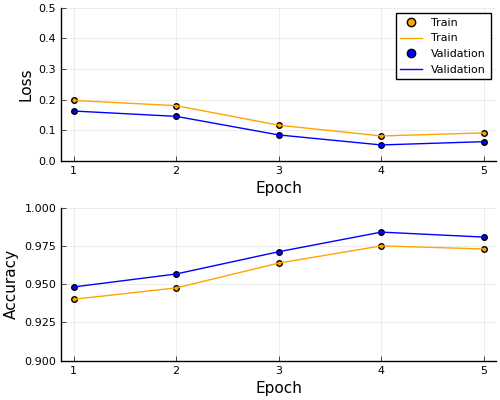

In [70]:
model = makeModel(:medium,2)
traces = trainModel(model,epochs = 5)
plotModel(traces)

# Task 1

- Repeat it for the 2-layer and 3-layer model.

You should get a figure similar as the following one:


# Task 2

What are you conclusions from this experiment ? which models present some overfit issue ? which models to keep ?



# Batch Normalization

In [74]:
? BatchNorm

search: BatchNorm batched_transpose



```
BatchNorm(channels::Integer, σ = identity;
          initβ = zeros, initγ = ones,
          ϵ = 1e-8, momentum = .1)
```

[Batch Normalization](https://arxiv.org/abs/1502.03167) layer. `channels` should be the size of the channel dimension in your data (see below).

Given an array with `N` dimensions, call the `N-1`th the channel dimension. (For a batch of feature vectors this is just the data dimension, for `WHCN` images it's the usual channel dimension.)

`BatchNorm` computes the mean and variance for each each `W×H×1×N` slice and shifts them to have a new mean and variance (corresponding to the learnable, per-channel `bias` and `scale` parameters).

Use [`testmode!`](@ref) during inference.

# Examples

```julia
m = Chain(
  Dense(28^2, 64),
  BatchNorm(64, relu),
  Dense(64, 10),
  BatchNorm(10),
  softmax)
```


In [76]:
model= Chain(flatten, 
             Dense(784, 128,relu),
             BatchNorm(128),
             Dense(128,64,relu),
             BatchNorm(64),
             Dense(64, 10), softmax)
traces = trainModel(model)
println("\nFinal validation accuracy = ", accuracy(validateSet..., model))

1: Validation Accuracy: 0.97
2: Validation Accuracy: 0.984
3: Validation Accuracy: 0.987
4: Validation Accuracy: 0.987
5: Validation Accuracy: 0.989
6: Validation Accuracy: 0.99
7: Validation Accuracy: 0.991
8: Validation Accuracy: 0.993
9: Validation Accuracy: 0.993
10: Validation Accuracy: 0.995
11: Validation Accuracy: 0.993
12: Validation Accuracy: 0.993
13: Validation Accuracy: 0.993
14: Validation Accuracy: 0.994
15: Validation Accuracy: 0.991
16: Validation Accuracy: 0.995
17: Validation Accuracy: 0.995
18: Validation Accuracy: 0.997
19: Validation Accuracy: 0.995
20: Validation Accuracy: 0.995
21: Validation Accuracy: 0.996
22: Validation Accuracy: 0.996
23: Validation Accuracy: 0.992
24: Validation Accuracy: 0.994
25: Validation Accuracy: 0.997

Final validation accuracy = 0.9969166666666667


In [78]:
preds = [predictor(img,model) for img in testImgs]
testAccuracy = sum(preds .== testLabels)/length(preds)

0.9774

## Regularization

Regularization is generally a good practice for overfitting issue. Here we explore $L_1$ and $L_2$ normalization:

Here the code for a model with batch normalization and $L_2$ regularization.


In [ ]:
#QQQQ to do

### Task

Present the result of the model with 3-layer with 256, 128 and 64 nodes per respective layer, with batch normalization  and with $L_2$ regularization components. 


## Dropout

An another avenue for overfitting issue is to use the **dropout** strategy.

In [ ]:
# QQQQ


## What about the initialization of the weight

Keep in mind that weight initialization can have an impact on both the convergence rate and
the accuracy of your network. In **Keras**, the argument **kernel_initializer** in the function **layer_dense** allows us to set up different weight initialization. The default is the "Glorot uniform" which draws samples from a uniform within $[-a,a]$ where $a=\sqrt{\frac{6}{(fan_i+fan_o)}}$ where $fan_i$ is the number of inputs in the weight tensor and $fan_o$ is the number of output in the weight tensor.

In [ ]:
# QQQQ


### Early stop

In [ ]:
#QQQQ

# Final Task

Present the performance of your final model on the test set:

- confusion matrix
- accuracy